[70 BERT微调](https://www.bilibili.com/video/BV15L4y1v7ts?spm_id_from=333.999.0.0&vd_source=1d3a7b81d826789081d8b6870d4fff8e)

<img src="picture/屏幕截图 2022-07-28 001539.png">

- 句子分类
  - 句子分类是把句子的第一个词进行向量化，然后将这个向量交给接下来的网络进行分类预测
  - 为什么仅仅用第一个词就能实现分类呢？
    - 李沐大佬的解释：
    - bert可以自学习，能够在后面的学习中更新参数，使得一个足够
    - bert在编码的过程中，就已经通过上下文进行了学习

<img src="picture/截屏2022-07-28 17.36.25.png">

- 命名实体识别
  - 识别一个词元是不是命名实体,例如人名, 机构, 位置
  - 将非特殊词元放进全连接层
- 将真正的token(不是cls seq pad这种), 取出后,放入全连接层
- 分类可以不止一种, 例如apple可以是iPhone 可以是吃的苹果

<img src="picture/截屏2022-07-28 17.58.55.png">

- 问题问答
  - 一个问题Q和一个描述文字A, 需要从A中找出一个片段作为回答
    - 片段A的长度会可能会比较长,因此bert也需要较大的长度
    - 答案一般是一个单词或者短语, 但也有部分是一个句子
  - 既然是去寻找描述的片段,其实问题可以等效为我去寻找片段的起点和终点
    - 问题等效为: 预测片段的开头和节尾 

- 可以看到,虽然nlp任务很多,但是在bert这边,基本上都只需要增加一个输出层就行了
- 当然不同的任务也会导致不同的输出层


In [19]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

### 加载预训练的BER

In [20]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

两个预训练好的BERT模型都包含一个定义词表的“vocab.json”文件和一个预训练参数的“pretrained.params”文件。我们实现了以下load_pretrained_model函数来加载预先训练好的BERT参数。

In [21]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    """
    d2l.download_extract('bert.small')
    
    """
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    # 这里只是
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    """
    加载预训练BERT参数
    torch.load_state_dict(), 主要用于加载预训练的参数
    """
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab


- 在Pytorch中构建好一个模型后，一般需要进行预训练权重中加载。torch.load_state_dict()函数就是用于将预训练的参数权重加载到新的模型之中，操作方式如下所示：
-  ```python
    sd_net = torchvision.models.resnte50(pretrained=False)
    sd_net.load_state_dict(torch.load('*.pth'), strict=True)
    ```
- 属性 strict; 当strict=True,要求预训练权重层数的键值与新构建的模型中的权重层数名称完全吻合；如果新构建的模型在层数上进行了部分微调，则上述代码就会报错：说key对应不上。

- 此时，如果我们采用strict=False 就能够完美的解决这个问题。也即，与训练权重中与新构建网络中匹配层的键值就进行使用，没有的就默认初始化。

为了便于在大多数机器上演示，我们将在本节中加载和微调经过预训练BERT的小版本（“bert.small”）。在练习中，我们将展示如何微调大得多的“bert.base”以显著提高测试精度。

In [22]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

### 微调BERT的数据集
- 对于SNLI数据集的下游任务自然语言推断，我们定义了一个定制的数据集类SNLIBERTDataset。
- 在每个样本中，前提和假设形成一对文本序列，并被打包成一个BERT输入序列，
- 片段索引用于区分BERT输入序列中的前提和假设。利用预定义的BERT输入序列的最大长度（max_len），持续移除输入文本对中较长文本的最后一个标记，直到满足max_len。为了加速生成用于微调BERT的SNLI数据集，我们使用4个工作进程并行生成训练或测试样本。

In [23]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        """
        这里就是主要的需要进行序列化的内容,由下面的_preprocess函数
        进行预处理
        """
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
                
    # 这里就不细看了,主要返回的东西就在这了
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [24]:
data_dir = d2l.download_extract('SNLI')
dataset = d2l.read_snli(data_dir, False)
all_premise_hypothesis_tokens = [[p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]
# all_premise_hypothesis_tokens是吧句子拆成了多个句子对的组合
all_premise_hypothesis_tokens[0]

[['this',
  'church',
  'choir',
  'sings',
  'to',
  'the',
  'masses',
  'as',
  'they',
  'sing',
  'joyous',
  'songs',
  'from',
  'the',
  'book',
  'at',
  'a',
  'church',
  '.'],
 ['the', 'church', 'has', 'cracks', 'in', 'the', 'ceiling', '.']]

过实例化SNLIBERTDataset类来生成训练和测试样本。这些样本将在自然语言推断的训练和测试期间进行小批量读取。

In [25]:
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                num_workers=num_workers)

read 549367 examples
read 9824 examples


### 微调BERT
- 用于自然语言推断的微调BERT只需要一个额外的多层感知机，该多层感知机由两个全连接层组成（请参见下面BERTClassifier类中的self.hidden和self.output）。这个多层感知机将特殊的“<cls>”词元的BERT表示进行了转换，该词元同时编码前提和假设的信息为自然语言推断的三个输出：蕴涵、矛盾和中性

In [26]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        # 这里的hidden主要是用于下一个句子预测用的全连接层
        # 源代码nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

在下文中，预训练的BERT模型bert被送到用于下游应用的BERTClassifier实例net中。在BERT微调的常见实现中，只有额外的多层感知机（net.output）的输出层的参数将从零开始学习。预训练BERT编码器（net.encoder）和额外的多层感知机的隐藏层（net.hidden）的所有参数都将进行微调。

In [27]:
net = BERTClassifier(bert)

回想一下，在 14.8节中，MaskLM类和NextSentencePred类在其使用的多层感知机中都有一些参数。这些参数是预训练BERT模型bert中参数的一部分，因此是net中的参数的一部分。然而，这些参数仅用于计算预训练过程中的遮蔽语言模型损失和下一句预测损失。这两个损失函数与微调下游应用无关，因此当BERT微调时，MaskLM和NextSentencePred中采用的多层感知机的参数不会更新（陈旧的，staled）。

为了允许具有陈旧梯度的参数，标志ignore_stale_grad=True在step函数d2l.train_batch_ch13中被设置。我们通过该函数使用SNLI的训练集（train_iter）和测试集（test_iter）对net模型进行训练和评估。。由于计算资源有限，训练和测试精度可以进一步提高：我们把对它的讨论留在练习中。

loss 0.522, train acc 0.790, test acc 0.781
8979.4 examples/sec on [device(type='cuda', index=0)]


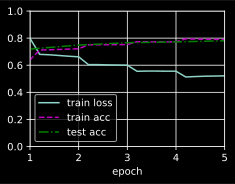

In [28]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)